In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import SGDClassifier, SGDRegressor
import lightgbm as lgb
from matplotlib import pyplot as plt
import joblib
from pathlib import Path
import sqlite3

In [2]:
pd.options.display.max_rows=650

In [3]:
connection = sqlite3.connect('../data/nba.db')


df = pd.read_sql('SELECT * FROM team_stats_ewa_matchup_prod', con=connection)
df = df.drop(columns=['index'])

connection.close()

df = df.sort_values('GAME_DATE')

df = df.dropna()

columns_to_drop = ['SEASON', 'HOME_TEAM_ABBREVIATION', 'GAME_DATE', 'GAME_ID', 'MATCHUP',
                     'HOME_HOME_GAME', 'HOME_TEAM_SCORE', 'HOME_ML', 'HOME_SPREAD',
                     'HOME_ATS_DIFF', 'HOME_TEAM_COVERED', 'HOME_POINT_DIFF',
                     'HOME_WL', 'AWAY_ML', 'AWAY_TEAM_SCORE',
                     'HOME_PTS_L5', 'HOME_PTS_L10', 'HOME_PTS_L20',
                     'HOME_PLUS_MINUS_L5', 'HOME_PLUS_MINUS_L10', 'HOME_PLUS_MINUS_L20',
                     'HOME_NET_RATING_L5', 'HOME_NET_RATING_L10', 'HOME_NET_RATING_L20',
                     'HOME_POSS_L5', 'HOME_POSS_L10', 'HOME_POSS_L20',
                     'HOME_PTS_opp_L5', 'HOME_PTS_opp_L10', 'HOME_PTS_opp_L20',
                     'HOME_PLUS_MINUS_opp_L5', 'HOME_PLUS_MINUS_opp_L10', 'HOME_PLUS_MINUS_opp_L20',
                     'HOME_NET_RATING_opp_L5', 'HOME_NET_RATING_opp_L10', 'HOME_NET_RATING_opp_L20',
                     'HOME_POSS_opp_L5', 'HOME_POSS_opp_L10', 'HOME_POSS_opp_L20',
                     'HOME_REB_L5', 'HOME_REB_L10', 'HOME_REB_L20',  
                     'HOME_REB_opp_L5', 'HOME_REB_opp_L10', 'HOME_REB_opp_L20',       
                     'AWAY_PTS_L5', 'AWAY_PTS_L10', 'AWAY_PTS_L20',
                     'AWAY_PLUS_MINUS_L5', 'AWAY_PLUS_MINUS_L10', 'AWAY_PLUS_MINUS_L20',
                     'AWAY_NET_RATING_L5', 'AWAY_NET_RATING_L10', 'AWAY_NET_RATING_L20',
                     'AWAY_POSS_L5', 'AWAY_POSS_L10', 'AWAY_POSS_L20',
                     'AWAY_PTS_opp_L5', 'AWAY_PTS_opp_L10', 'AWAY_PTS_opp_L20',
                     'AWAY_PLUS_MINUS_opp_L5', 'AWAY_PLUS_MINUS_opp_L10', 'AWAY_PLUS_MINUS_opp_L20',
                     'AWAY_NET_RATING_opp_L5', 'AWAY_NET_RATING_opp_L10', 'AWAY_NET_RATING_opp_L20',
                     'AWAY_POSS_opp_L5', 'AWAY_POSS_opp_L10', 'AWAY_POSS_opp_L20',
                     'AWAY_REB_L5', 'AWAY_REB_L10', 'AWAY_REB_L20',
                     'AWAY_REB_opp_L5', 'AWAY_REB_opp_L10', 'AWAY_REB_opp_L20']

train_df = df.loc[df['SEASON'] < '2021-22']
test_df = df.loc[df['SEASON'] >= '2021-22']


X_train = train_df.drop(columns=columns_to_drop)
y_train = train_df['HOME_WL']

X_test = test_df.drop(columns=columns_to_drop)
y_test = test_df['HOME_WL']

train_df.shape, test_df.shape

((9721, 645), (1668, 645))

In [12]:
# test_df.loc[test_df['MATCHUP'].str.contains('BOS')].sort_values('GAME_DATE')

In [13]:
con = sqlite3.connect('../data/nba.db')
pd.read_sql("SELECT name FROM sqlite_schema WHERE type='table'", con)

,name
0,moneylines
1,team_basic_boxscores
2,team_advanced_boxscores
3,team_scoring_boxscores
4,spreads
5,player_tracking_boxscores
6,team_tracking_boxscores
7,team_stats_ewa_matchup
8,team_stats_ewa_matchup_dev
9,team_stats_ewa_matchup_prod


In [18]:
pd.read_sql("""SELECT * FROM team_advanced_boxscores
                limit 1""", con)

,GAME_ID,TEAM_ID,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CITY,MIN,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,...,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE
0,0020000008,1610612750,Timberwolves,MIN,Minnesota,240:00,108.1,110.4,99.4,103.2,...,16.7,0.523,0.558,1.0,0.195,98.32,95.5,79.58,96,0.554


In [20]:
pd.read_sql("""SELECT * FROM team_basic_boxscores a
                LEFT JOIN team_advanced_boxscores b
                ON a.GAME_ID = b.GAME_ID
                AND a.TEAM_ID = b.TEAM_ID
                LEFT JOIN team_scoring_boxscores c
                ON a.GAME_ID = c.GAME_ID
                AND a.TEAM_ID = c.TEAM_ID
                WHERE a.matchup like '%BOS%'
                AND a.game_date >= '2022-12-16'""", con)

,SEASON,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,PCT_PTS_FB,PCT_PTS_FT,PCT_PTS_OFF_TOV,PCT_PTS_PAINT,PCT_AST_2PM,PCT_UAST_2PM,PCT_AST_3PM,PCT_UAST_3PM,PCT_AST_FGM,PCT_UAST_FGM
0,2022-23,1610612738,BOS,Boston Celtics,0022200430,2022-12-16,BOS vs. ORL,L,240,35,...,0.055,0.257,0.211,0.422,0.375,0.625,0.727,0.273,0.486,0.514
1,2022-23,1610612753,ORL,Orlando Magic,0022200430,2022-12-16,ORL @ BOS,W,240,42,...,0.077,0.205,0.128,0.410,0.333,0.667,0.889,0.111,0.452,0.548
2,2022-23,1610612753,ORL,Orlando Magic,0022200445,2022-12-18,ORL @ BOS,W,240,33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-23,1610612738,BOS,Boston Celtics,0022200445,2022-12-18,BOS vs. ORL,L,240,31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
pd.read_sql("""SELECT * FROM team_scoring_boxscores
                WHERE GAME_ID = '0022200445'""", con)

,GAME_ID,TEAM_ID,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CITY,MIN,PCT_FGA_2PT,PCT_FGA_3PT,PCT_PTS_2PT,PCT_PTS_2PT_MR,...,PCT_PTS_FB,PCT_PTS_FT,PCT_PTS_OFF_TOV,PCT_PTS_PAINT,PCT_AST_2PM,PCT_UAST_2PM,PCT_AST_3PM,PCT_UAST_3PM,PCT_AST_FGM,PCT_UAST_FGM
0,0022200445,1610612753,Magic,ORL,Orlando,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,0022200445,1610612738,Celtics,BOS,Boston,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [5]:
def view_model_coefs(model, X_train, plot_graph = True, remove_zero_coefs=True):
    feature_names = X_train.columns
    
    try:
        coefficients = model.coef_
    except:
        print("LGBoost or XGBoost")
        coefficients = model.feature_importances_

    coef_df = pd.DataFrame({'feature_name':feature_names,
                'coef':coefficients})
    if remove_zero_coefs:
        coef_df = coef_df.loc[coef_df['coef']!=0].sort_values('coef')
    
    if plot_graph:
        top_20_features = pd.concat([coef_df.head(10), coef_df.tail(10)])
        top_20_features.plot.barh('feature_name', figsize=(6,12))
    
    return coef_df

In [6]:
filename = 'SGDRegressor_ScorePredictor.sav'
model_location = Path.home().joinpath('NBA_model_v1', 'models', filename)

best_sgd_reg = joblib.load(model_location)


In [7]:
filename = 'LGBRegressor.sav'
model_location = Path.home().joinpath('NBA_model_v1', 'models', filename)

best_lgb_reg = joblib.load(model_location)

In [8]:
best_sgd_reg.named_steps['sgd'].estimators_[0].coef_

array([ 2.77647348e+00, -3.68073116e-01,  2.83025939e-02,  5.37574450e-01,
        5.75425898e-01, -6.49172412e-02,  1.58627860e-01, -1.75566474e-01,
       -3.10221314e-01, -1.00787008e-02,  3.34986289e-01, -1.47583726e-01,
       -7.42551862e-02, -2.31902000e-01,  1.26149843e-01,  4.14665863e-02,
       -1.32395463e-01, -1.23260225e-02,  1.49808992e-01,  9.76475336e-02,
       -1.66551052e-01, -1.41935936e-01, -2.14049340e-01, -1.65125140e-01,
       -2.01295206e-01,  8.92143084e-02, -5.42101343e-01,  3.51046582e-01,
        3.60766601e-01, -8.23333397e-02, -2.39046426e-01, -1.95893702e-01,
       -7.76923713e-03, -5.35416295e-01, -2.59027149e-01,  7.44141609e-02,
       -5.86922509e-01, -1.16714592e-01, -3.57560056e-01, -4.84164204e-02,
       -1.05517095e-02, -1.30484600e-01, -2.09403151e-01, -3.24714590e-03,
       -1.85514474e-01, -9.52285094e-02,  2.62624339e-02, -1.23861382e-01,
       -7.59567066e-02,  2.33869550e-02, -4.64184709e-02, -5.20620292e-02,
        1.26149843e-01, -

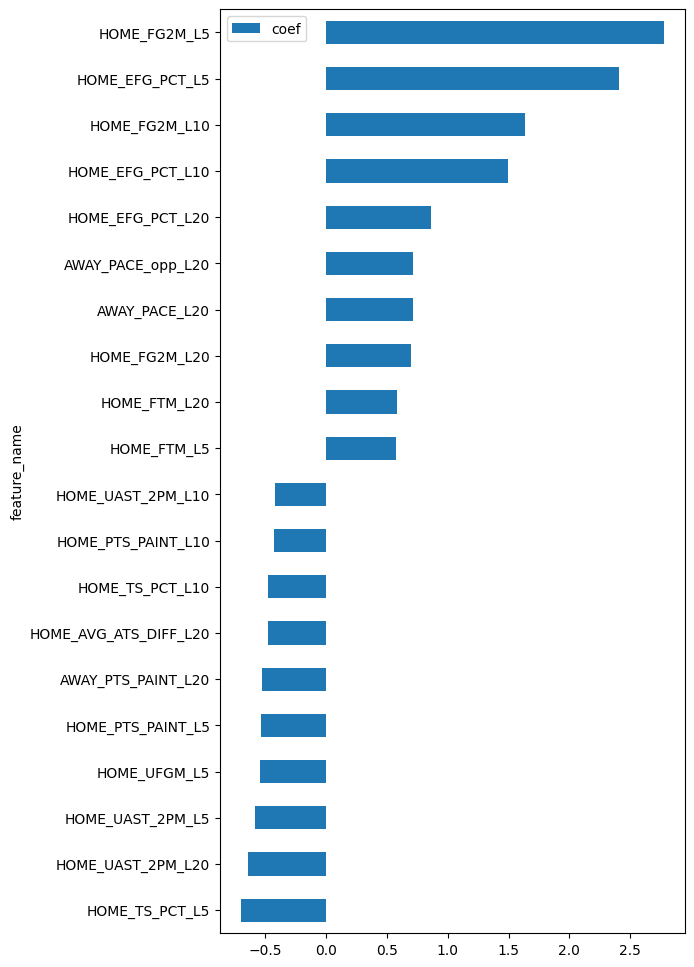

In [9]:
sgd_coef_df = view_model_coefs(best_sgd_reg.named_steps['sgd'].estimators_[0], X_train)

In [10]:
sgd_coef_df.sort_values(['coef'], ascending=False)

,feature_name,coef
0,HOME_FG2M_L5,2.776473
87,HOME_EFG_PCT_L5,2.409453
94,HOME_FG2M_L10,1.635541
181,HOME_EFG_PCT_L10,1.494109
275,HOME_EFG_PCT_L20,0.863440
527,AWAY_PACE_opp_L20,0.717559
488,AWAY_PACE_L20,0.717559
188,HOME_FG2M_L20,0.701500
192,HOME_FTM_L20,0.585336
4,HOME_FTM_L5,0.575426


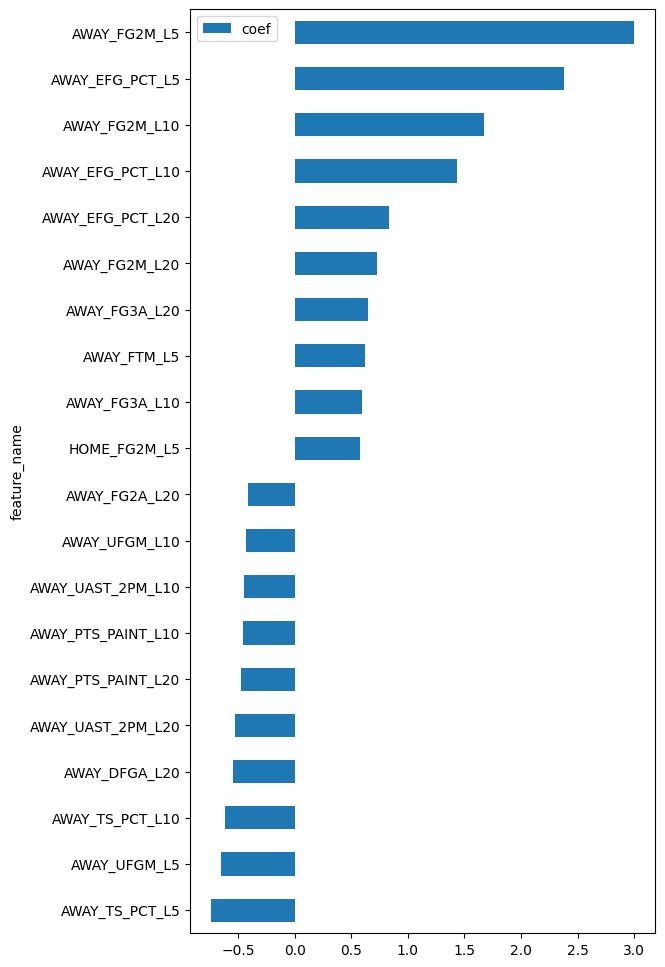

In [21]:
sgd_coef_df = view_model_coefs(best_sgd_reg.named_steps['sgd'].estimators_[1], X_train)

,feature_name,coef
77,HOME_WIN_PCT_L5,0.043270
265,HOME_WIN_PCT_L20,-0.187209
171,HOME_WIN_PCT_L10,-0.218156
65,HOME_UFGM_opp_L5,-0.085541
253,HOME_UFGM_opp_L20,-0.090771
159,HOME_UFGM_opp_L10,-0.128072
26,HOME_UFGM_L5,-0.227882
214,HOME_UFGM_L20,-0.081637
120,HOME_UFGM_L10,-0.175337
66,HOME_UFGA_opp_L5,0.047581


LGBoost or XGBoost


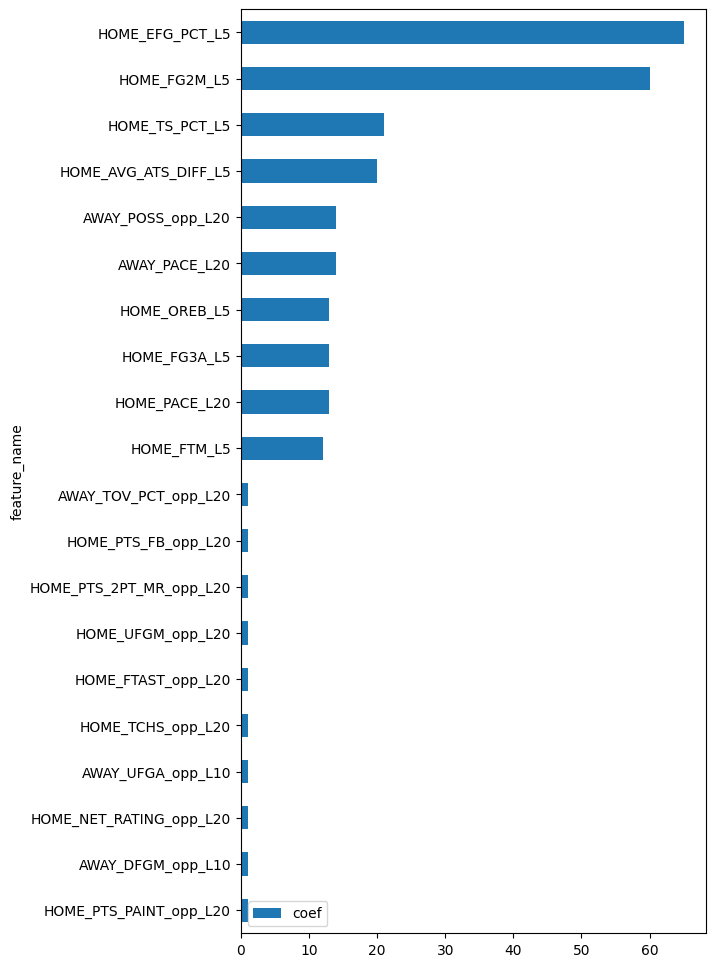

In [13]:
lgb_coef_df = view_model_coefs(best_lgb_reg.estimators_[0], X_train)

LGBoost or XGBoost


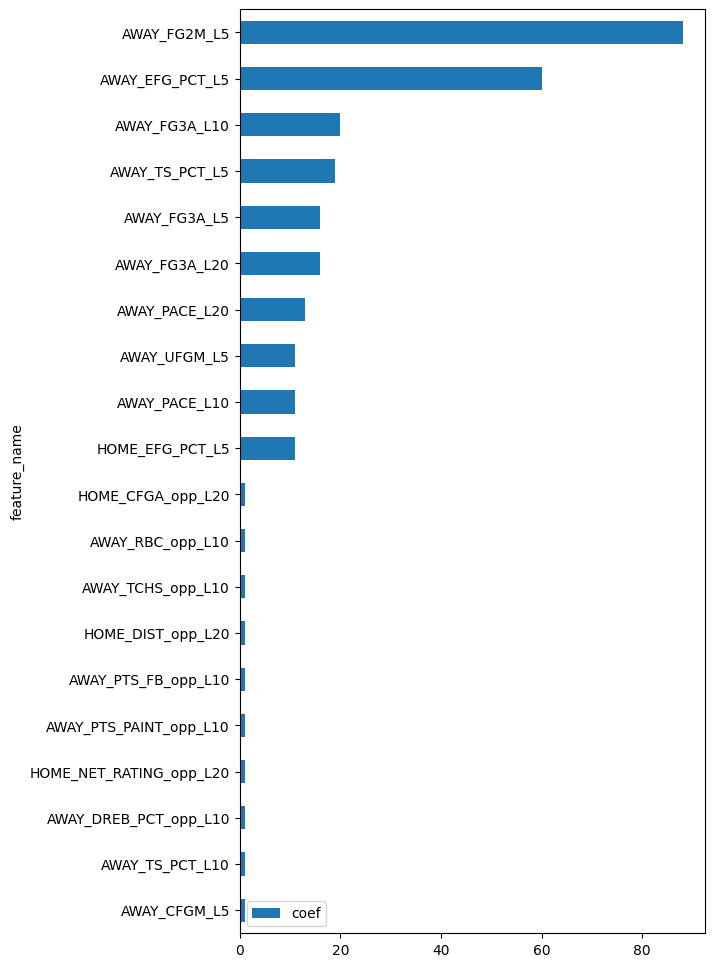

In [14]:
lgb_coef_df = view_model_coefs(best_lgb_reg.estimators_[1], X_train)